In [1]:
from lgnpy.CEandSC.lgn_statistics import lgn_statistics, interp1d
# conv2padded, filter_lgn, create_hist, local_cov
from result_manager.result_manager import ResultManager
from lgnpy.run_LGNstatistics import loadmat
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import zscore
import os
from sklearn.linear_model import LinearRegression
import multiprocessing
import warnings
import tqdm
from scipy.optimize import minimize

In [2]:
erp = loadmat('/home/niklas/projects/eeg_jneurosc13/ERPs_singlesubjects14_singletrials_behexcluded.mat')
sensors = erp['sensors']
data = erp['Y']

# Setup

In [3]:
# viewing_dist=1
# dot_pitch=0.00035
# fov_beta=1.5
# fov_gamma=5

# # if im.shape[-1] == 2:
# #     IMTYPE = 1  # Gray
# # elif im.shape[-1] == 3:
# IMTYPE = 2  # Color

# # imsize = im.shape[:2]
# imsize = (480, 640)

# #######################################################
# # Set parameters for field of view
# #######################################################

def setup(imsize, viewing_dist=1, dot_pitch=0.00035, fov_beta=1.5, fov_gamma=5):

    fovx = round(imsize[1]/2)          # x-pixel loc. of fovea center
    fovy = round(imsize[0]/2)          # y-pixel loc. of fovea center
    # ex and ey are the x- and y- offsets of each pixel compared to
    # the point of focus (fovx,fovy) in pixels.
    ex, ey = np.meshgrid(np.arange(start=-fovx+1, stop=imsize[1]-fovx+1),
                        np.arange(start=-fovy+1, stop=imsize[0]-fovy+1))
    # eradius is the radial distance between each point and the point
    # of gaze.  This is in meters.
    eradius = dot_pitch * np.sqrt(ex**2+ey**2)
    #del ex, ey
    # calculate ec, the eccentricity from the foveal center, for each
    # point in the image.  ec is in degrees.
    ec = 180*np.arctan(eradius / viewing_dist)/np.pi
    # select the pixels that fall within the input visual field of view
    imfovbeta = (ec < fov_beta)
    imfovgamma = (ec < fov_gamma)

    return imfovbeta, imfovgamma

In [4]:
threshold_lgn = loadmat('/home/niklas/projects/LGNstatistics-master/CEandSCmatlab/ThresholdLGN.mat')
threshold_lgn = threshold_lgn['ThresholdLGN']

Could not load mat file with mat73 - trying to load with scipy.io.loadmat!


# Get CE/SC

In [5]:
root = '/home/niklas/projects/eeg_jneurosc13/allstim/'
image_names = [f for f in os.listdir(root) if os.path.join(root, f).endswith('jpg')]

In [6]:
def iterate(args):
    image_name, image_index, config = args
    im = Image.open(os.path.join('/home/niklas/projects/eeg_jneurosc13/allstim/', image_name))
    im = np.array(im)

    (ce, sc, beta, gamma) = lgn_statistics(im=im, file_name=image_name, config=config, threshold_lgn=threshold_lgn)

    return ce, sc, image_index

In [7]:
# def iterate(args):
#     image_name, image_index, par_sigmas, mag_sigmas, viewing_dist = args
#     im = Image.open(os.path.join('/home/niklas/projects/eeg_jneurosc13/allstim/', image_name))
#     im = np.array(im)
#     imsize = im.shape[:2]
#     if im.shape[-1] == 2:
#         IMTYPE = 1  # Gray
#     elif im.shape[-1] == 3:
#         IMTYPE = 2  # Color

#     imfovbeta, imfovgamma = setup(imsize=imsize, viewing_dist=viewing_dist)

        
#     # for image_index, im in enumerate(images):
#     ce = np.zeros((im.shape[-1], 1, 2))
#     # ce_extra = []
#     sc = np.zeros((im.shape[-1], 1, 2))
#     # imsize = im.shape
#     par1 = np.zeros(imsize)
#     par2 = np.zeros(imsize)
#     par3 = np.zeros(imsize)
#     mag1 = np.zeros(imsize)
#     mag2 = np.zeros(imsize)
#     mag3 = np.zeros(imsize)

#     # par_sigmas = [48, 24, 12, 6, 3]
#     # mag_sigmas = [64, 32, 16, 8, 4]
#     if os.path.exists(os.path.join('/home/niklas/projects/lgnpy/cache/', f'results_{image_name}.npy')):
#         results = np.load(os.path.join('/home/niklas/projects/lgnpy/cache/', f'results_{image_name}.npy'))
#         par1, par2, par3, mag1, mag2, mag3 = results
#     else:
#         for iteration_index, sigma_iterations in enumerate(np.array([par_sigmas, mag_sigmas])):
#             for _, sigma in enumerate(sigma_iterations):

#                 sigmas = np.array([1, 2, 4, 8, 16, 32])
#                 v1 = np.squeeze(threshold_lgn[:, 0])
#                 t1_interp = interp1d(sigmas, v1, kind='linear',
#                                     bounds_error=False, fill_value=np.nan)
#                 t1 = t1_interp(sigma)
#                 v2 = np.squeeze(threshold_lgn[:, 1])
#                 t2_interp = interp1d(sigmas, v2, kind='linear',
#                                     bounds_error=False, fill_value=np.nan)
#                 t2 = t2_interp(sigma)
#                 v3 = np.squeeze(threshold_lgn[:, 2])
#                 t3_interp = interp1d(sigmas, v3, kind='linear',
#                                     bounds_error=False, fill_value=np.nan)
#                 t3 = t3_interp(sigma)

#                 o1, o2, o3 = filter_lgn(im, sigma)

#                 s1 = local_cov(o1, sigma)
#                 with warnings.catch_warnings():
#                     warnings.simplefilter("ignore", category=RuntimeWarning)
#                     e1 = ((o1 * np.max(o1)) / (o1 + np.max(o1) * s1))
#                 minm1 = e1 - t1
#                 index1 = (minm1 > 0.0000001)
#                 if iteration_index == 0:
#                     par1[index1] = minm1[index1]
#                 elif iteration_index == 1:
#                     mag1[index1] = minm1[index1]

#                 if IMTYPE == 2:
#                     s2 = local_cov(o2, sigma)
#                     with warnings.catch_warnings():
#                         warnings.simplefilter("ignore", category=RuntimeWarning)
#                         e2 = ((o2 * np.max(o2)) / (o2 + np.max(o2) * s2))
#                     minm2 = e2 - t2
#                     index2 = (minm2 > 0.0000001)
#                     if iteration_index == 0:
#                         par2[index2] = minm2[index2]
#                     elif iteration_index == 1:
#                         mag2[index2] = minm2[index2]

#                     s3 = local_cov(o3, sigma)
#                     with warnings.catch_warnings():
#                         warnings.simplefilter("ignore", category=RuntimeWarning)
#                         e3 = ((o3 * np.max(o3)) / (o3 + np.max(o3) * s3))
#                     minm3 = e3 - t3
#                     index3 = (minm3 > 0.0000001)
#                     if iteration_index == 0:
#                         par3[index3] = minm3[index3]
#                     elif iteration_index == 1:
#                         mag3[index3] = minm3[index3]


#     magnitude = np.abs(par1[imfovbeta])
#     ce[0, 0, 0] = np.mean(magnitude)
#     if IMTYPE == 2:
#         magnitude = np.abs(par2[imfovbeta])
#         ce[1, 0, 0] = np.mean(magnitude)
#         magnitude = np.abs(par3[imfovbeta])
#         ce[2,0,0] = np.mean(magnitude)

#     magnitude = np.abs(mag1[imfovgamma])
#     sc[0,0,0] = np.mean(magnitude) / np.std(magnitude)
#     if IMTYPE == 2:
#         magnitude = np.abs(mag2[imfovgamma])
#         sc[1,0,0] = np.mean(magnitude) / np.std(magnitude)
#         magnitude = np.abs(mag3[imfovgamma])
#         sc[2,0,0] = np.mean(magnitude) / np.std(magnitude)

#     return ce, sc, image_index

def get_sc_ce(image_names, threshold_lgn, config):
    ces = np.zeros((len(image_names), 3, 1, 2))
    scs = np.zeros((len(image_names), 3, 1, 2))


    with multiprocessing.Pool() as pool:
        results = list(tqdm.tqdm(pool.imap(iterate, [(image_name, index, config) for index, image_name in enumerate(image_names)]), total=len(image_names)))
    
    for ce, sc, index in results:
        ces[index, :,:,:] = ce
        scs[index, :,:,:] = sc

    return ces, scs

## Create Design Matrix

In [8]:
def regression(ces, scs):
    ce_avg = zscore(np.mean(ces[:,:,0,0], axis=-1))
    sc_avg = zscore(np.mean(scs[:,:,0,0], axis=-1))

    if len(ce_avg.shape) > 1:
        c = np.ones((ce_avg.shape[0], 1)) #* np.mean(ce_avg)
        zeros = np.zeros(ce_avg.shape)
        rep1 = np.hstack((c, ce_avg, zeros, sc_avg, zeros))
        rep2 = np.hstack((c, zeros, ce_avg, zeros, sc_avg))
        design_matrix = np.vstack((rep1, rep2))
    else:
        c = np.ones((ce_avg.shape[0])) #* np.mean(ce_avg)
        zeros = np.zeros(ce_avg.shape)
        rep1 = np.vstack((c, ce_avg, zeros, sc_avg, zeros))
        rep2 = np.vstack((c, zeros, ce_avg, zeros, sc_avg))
        design_matrix = np.hstack((rep1, rep2)).T

    r2_sensors = {}
    beta_sensors = {}
    res = []
    for sensor_index, sensor in [(43, 'Oz')]:
        r2_subjects = {}
        beta_subjects = {}
        for subject in range(14):
            r2s = []
            betas = []
            for time_index in range(154):
                y = np.hstack((data[subject,time_index,sensor_index,:len(image_names)], data[subject,time_index,sensor_index,:len(image_names)]))
                mask = np.isnan(y)
                x = design_matrix[~mask]
                y = zscore(y[~mask])

                lin_reg = LinearRegression().fit(x, y)
                r2 = lin_reg.score(x,y)
                beta = lin_reg.coef_

                r2s.append(r2)
                betas.append(beta)

            r2_subjects[subject] = r2s
            beta_subjects[subject] = betas

        # res.append(r2_subjects.values())

    r2_sensors[sensor] = r2_subjects
    beta_sensors[sensor] = beta_subjects
    
    return (r2_sensors, beta_sensors)

In [9]:
# This needs to take any input variable, not sure how to do this. Easiest and most flexible would be to have any loose variable defined in a dictionary
def comb(image_names, threshold_lgn, config):
    ces, scs = get_sc_ce(image_names, threshold_lgn=threshold_lgn, config=config)
    return regression(ces, scs)

In [ ]:
configs = [{
    'viewing_dist': 1
},
{
    'viewing_dist': 5
}]

res = []

# for viewing_dist in [0.5, 0.8, 1.0, 1.5]:
for config in configs:
    res.append(comb(image_names=image_names, threshold_lgn=threshold_lgn, config=config))

In [ ]:
res[0]

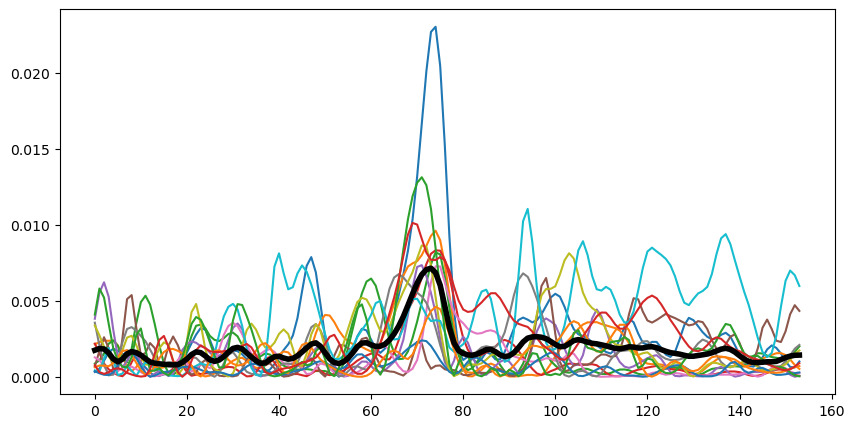

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
for sub in range(14):
    ax.plot(res[1][0]['Oz'][sub])

ax.plot(np.mean(np.array([x for _, x in res[1][0]['Oz'].items()]), axis=0), 'k', linewidth=4.0)

In [ ]:
for viewing_dist, r2_sensors in zip([0.5, 0.8, 1.0, 1.5], res):
    for r2_subjects in r2_sensors[0]:
        print(r2_subjects)